In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import scvi

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"

In [3]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
SLN_206_adata = sc.read(f"{save_path}/spleen_lymph_206.h5ad")
SLN_111_adata = sc.read(f"{save_path}/spleen_lymph_111.h5ad")

In [4]:
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in SLN_111_adata.uns["protein_names"]]
)
SLN_111_adata.obsm["protein_expression"] = SLN_111_adata.obsm["protein_expression"][
    :, keep_pro_111
]
SLN_111_adata.uns["protein_names"] = SLN_111_adata.uns["protein_names"][keep_pro_111]

In [5]:
keep_pro_206 = np.array(
    [not p.startswith("HTO") for p in SLN_206_adata.uns["protein_names"]]
)
SLN_206_adata.obsm["protein_expression"] = SLN_206_adata.obsm["protein_expression"][
    :, keep_pro_206
]
SLN_206_adata.uns["protein_names"] = SLN_206_adata.uns["protein_names"][keep_pro_206]

In [6]:
rna_data_111 = ad.AnnData(
    X=SLN_111_adata.X,
    obs=SLN_111_adata.obs,
    var=pd.DataFrame(index=SLN_111_adata.var.index),
)
rna_data_111.obs['n_counts']  = rna_data_111.X.sum(axis=1)
rna_data_111.obs['panel']  = '111'
rna_data_111.obs_names = 'p111_'+rna_data_111.obs_names

In [7]:
rna_data_206 = ad.AnnData(
    X=SLN_206_adata.X,
    obs=SLN_206_adata.obs,
    var=pd.DataFrame(index=SLN_206_adata.var.index),
)
rna_data_206.obs['n_counts']  = rna_data_206.X.sum(axis=1)
rna_data_206.obs['panel']  = '206'
rna_data_206.obs_names = 'p206_'+rna_data_206.obs_names

In [8]:
protein_data_111 = ad.AnnData(
    X=np.array(SLN_111_adata.obsm["protein_expression"]),
    obs=SLN_111_adata.obs.copy(),
    var=SLN_111_adata.uns["protein_names"].copy()
)
protein_data_111.var_names = SLN_111_adata.uns["protein_names"]
protein_data_111.var = protein_data_111.var.drop(columns=0)
protein_data_111.obs['n_counts']  = protein_data_111.X.sum(axis=1)
protein_data_111.obs['panel']  = '111'
protein_data_111.obs_names = 'p111_'+protein_data_111.obs_names

In [9]:
protein_data_206 = ad.AnnData(
    X=np.array(SLN_206_adata.obsm["protein_expression"]),
    obs=SLN_206_adata.obs.copy(),
    var=SLN_206_adata.uns["protein_names"].copy()
)
protein_data_206.var_names = SLN_206_adata.uns["protein_names"]
protein_data_206.var = protein_data_206.var.drop(columns=0)
protein_data_206.obs['n_counts']  = protein_data_206.X.sum(axis=1)
protein_data_206.obs['panel']  = '206'
protein_data_206.obs_names = 'p206_'+protein_data_206.obs_names

In [10]:
# merge the rna adata of the two datasets
rna_adata_pool = ad.concat([rna_data_111, rna_data_206], join="outer", axis=0)

In [11]:
protein_adata_pool = ad.concat([protein_data_111, protein_data_206], join="outer", axis=0)

In [12]:
protein_adata_intersect = ad.concat([protein_data_111, protein_data_206], join="inner", axis=0)
protein_adata_intersect 

AnnData object with n_obs × n_vars = 32648 × 110
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'

In [35]:
rna_adata_pool

AnnData object with n_obs × n_vars = 32648 × 13553
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'

# Preprocess

In [13]:
mdata = mu.MuData({
    "rna": rna_adata_pool,
    "protein": protein_adata_intersect,
})

In [14]:
rna_adata_pool.var['mt'] = rna_adata_pool.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_adata_pool, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

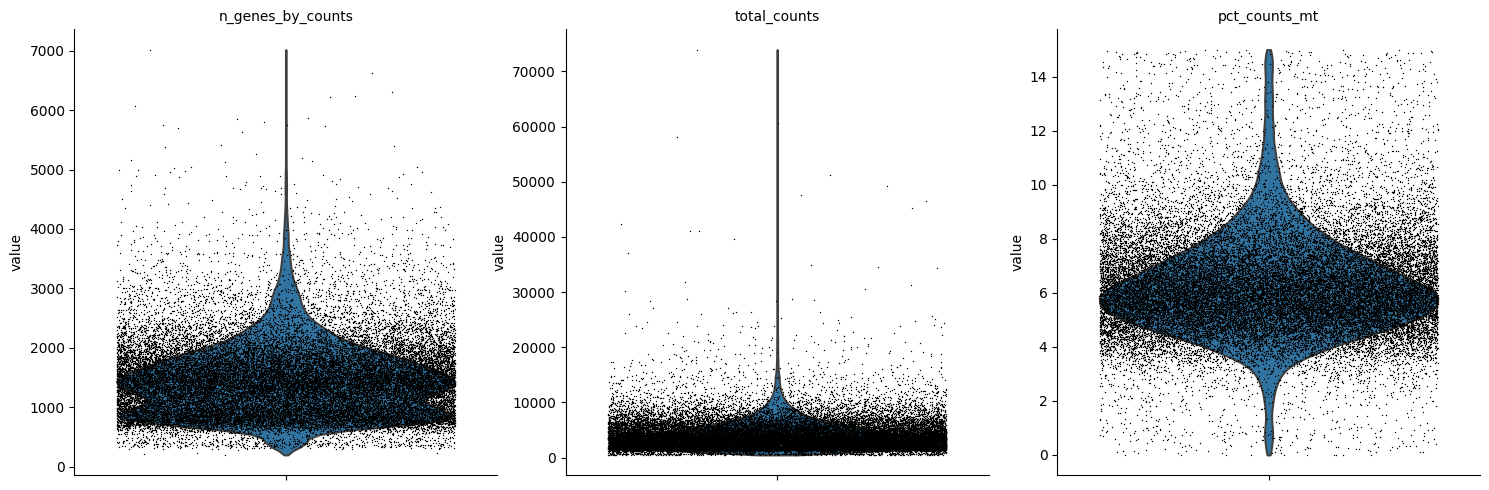

In [38]:
sc.pl.violin(rna_adata_pool, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [15]:
rna_adata_pool.layers["counts"] = rna_adata_pool.X.copy()

In [16]:
sc.pp.normalize_total(rna_adata_pool, target_sum=1e4)
sc.pp.log1p(rna_adata_pool)
rna_adata_pool.obs_names_make_unique()

In [17]:
sc.pp.highly_variable_genes(
    rna_adata_pool,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch_indices",
    layer="counts",
)

In [18]:
sc.tl.pca(rna_adata_pool, svd_solver='arpack')
sc.pp.neighbors(rna_adata_pool, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna_adata_pool, resolution=.75)
sc.tl.umap(rna_adata_pool, spread=1., min_dist=.5, random_state=42)

In [43]:
rna_adata_pool.write_h5ad(f"{save_path}/rna_pool.h5ad")

In [44]:
protein_adata_pool.layers["counts"] = protein_adata_pool.X.copy()
# sc.pp.normalize_total(protein_adata_pool, target_sum=1e4)
# sc.pp.log1p(protein_adata_pool)

In [19]:
# protein_adata_pool.layers["counts"] = np.nan_to_num(protein_adata_pool.layers["counts"], nan=0.0)
protein_adata_pool.X = protein_adata_pool.layers["counts"].copy()
sc.pp.normalize_total(protein_adata_pool, target_sum=1e4)
sc.pp.log1p(protein_adata_pool)

KeyError: 'counts'

In [46]:
protein_adata_pool.write_h5ad(f"{save_path}/protein_pool.h5ad")

In [21]:
protein_adata_intersect.layers["counts"] = protein_adata_intersect.X

In [22]:
protein_adata_intersect.layers["counts"] = np.nan_to_num(protein_adata_intersect.layers["counts"], nan=0.0)
protein_adata_intersect.X = np.nan_to_num(protein_adata_intersect.X, nan=0.0)
sc.pp.normalize_total(protein_adata_intersect, target_sum=1e4)
sc.pp.log1p(protein_adata_intersect)

In [23]:
protein_adata_intersect.write(f"{save_path}/scCITE_intersect_protein.h5ad")
# mdata.write_h5mu(f"{save_path}/scCITE_intersect.h5mu")

In [53]:
mdata.write_h5mu(f"{save_path}/scCITE_combine.h5mu")

# GraphCrossAttn

In [3]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
from models.dataset import GeneVocab, SinglecellData

In [4]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
rna_adata_pool = ad.read_h5ad(f"{save_path}/rna_pool.h5ad")
# protein_adata_pool = ad.read_h5ad(f"{save_path}/protein_pool.h5ad")
protein_adata_intersect = ad.read_h5ad(f"{save_path}/scCITE_intersect_protein.h5ad")

## With highly variable

In [5]:
rna_adata_pool

AnnData object with n_obs × n_vars = 32648 × 13553
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
rna_adata_pool_subset = rna_adata_pool[:, rna_adata_pool.var["highly_variable"]]
rna_adata_pool_subset = rna_adata_pool_subset[:, 
        rna_adata_pool_subset.var.sort_values(by="highly_variable_rank").index]

In [7]:
highly_variable_names = rna_adata_pool_subset.var_names.to_list()
# df = pd.DataFrame(highly_variable_names)
# df.to_csv(f"{save_path}/scCITE_hvg.csv", index=False)

In [8]:
from models.dataset import create_graphData, split_data

num_splits = 1
num_val = 0.2
num_test = 0.2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

graph_data = create_graphData(rna_adata_pool_subset, protein_adata_intersect, device)
training_data = split_data(graph_data, num_splits=num_splits, num_val=num_val, num_test=num_test)

In [9]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_adata_pool_subset.X.shape[1]
prot_input_dim = protein_adata_intersect.X.shape[1]

hidden_dim = 64
embedding_dim = 64
heads = 4
num_blocks = 2
permute = True
preserve_rate = 0.9
alpha = 0.6
beta = 0.1
GAT_encoding = False

# setting for the trainer
batch_size = 512
lr = 1e-5
epochs = 10
mask_ratio = 0.85

In [28]:
# import importlib
# import sys

# importlib.reload(sys.modules['train'])

In [10]:
from models.train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice,
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
    GAT_encoding=GAT_encoding,
)

trainer.train(plot_loss=False)

Epoch 1/10 train_loss: 368.55878 val_loss: 86.25320
Epoch 2/10 train_loss: 362.01420 val_loss: 84.09075
Epoch 3/10 train_loss: 344.86305 val_loss: 79.43473
Epoch 4/10 train_loss: 322.84264 val_loss: 75.83403
Epoch 5/10 train_loss: 303.95335 val_loss: 72.21119
Epoch 6/10 train_loss: 282.83252 val_loss: 68.71550
Epoch 7/10 train_loss: 265.15452 val_loss: 65.42307
Epoch 8/10 train_loss: 251.71520 val_loss: 62.14202
Epoch 9/10 train_loss: 239.88872 val_loss: 58.73928
Epoch 10/10 train_loss: 228.78180 val_loss: 55.11548
Best model saved at split 0


In [94]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/scCITE_intersect_hvg.pt")

In [11]:
mudata = mu.MuData({
    "rna": rna_adata_pool,
    "prot": protein_adata_intersect,
})

In [12]:
mudata.obsm["GCAT_embedding"] = trainer.get_embedding(graph_data)

In [13]:
# Clustering based on the embedding
sc.pp.neighbors(mudata, use_rep="GCAT_embedding", key_added="GCAT_neighbors")
sc.tl.umap(mudata, random_state=1, neighbors_key="GCAT_neighbors")

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


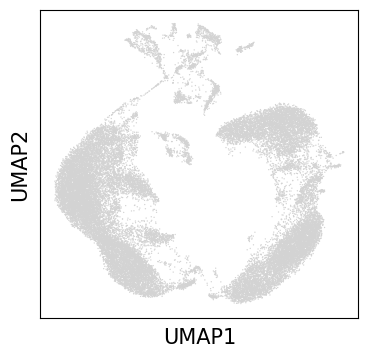

In [14]:
plt.rcParams["figure.figsize"] = (4.1,4)
plt.rcParams.update({'font.size': 15}) #设定全局字体大小
# sc.pl.umap(adata,color=['1364','1007','225','1956'],wspace=0.4)
sc.pl.umap(mudata,wspace=0.4)

In [15]:
mudata.obs["batch"] = mudata['rna'].obs["batch_indices"]

Epoch 1/10 train_loss: 602.25388 val_loss: 145.99321
Epoch 2/10 train_loss: 502.02521 val_loss: 118.43987
Epoch 3/10 train_loss: 366.75129 val_loss: 82.60500
Epoch 4/10 train_loss: 261.00908 val_loss: 52.03239
Epoch 5/10 train_loss: 187.42318 val_loss: 36.29820
Epoch 6/10 train_loss: 148.95621 val_loss: 28.38974
Epoch 7/10 train_loss: 131.41694 val_loss: 25.29600
Epoch 8/10 train_loss: 125.48408 val_loss: 24.52156
Epoch 9/10 train_loss: 124.06561 val_loss: 24.19645
Epoch 10/10 train_loss: 123.63811 val_loss: 24.12862
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


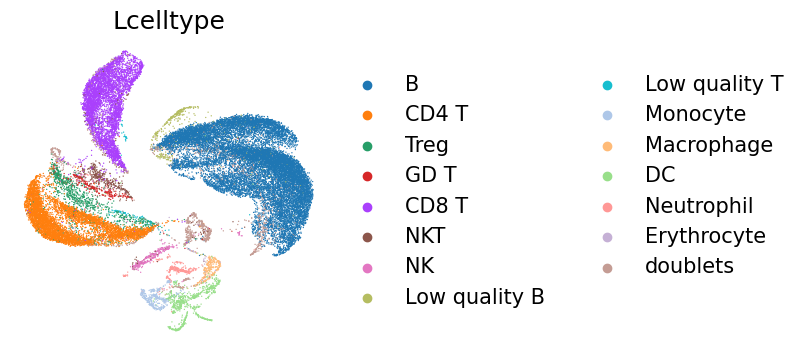

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


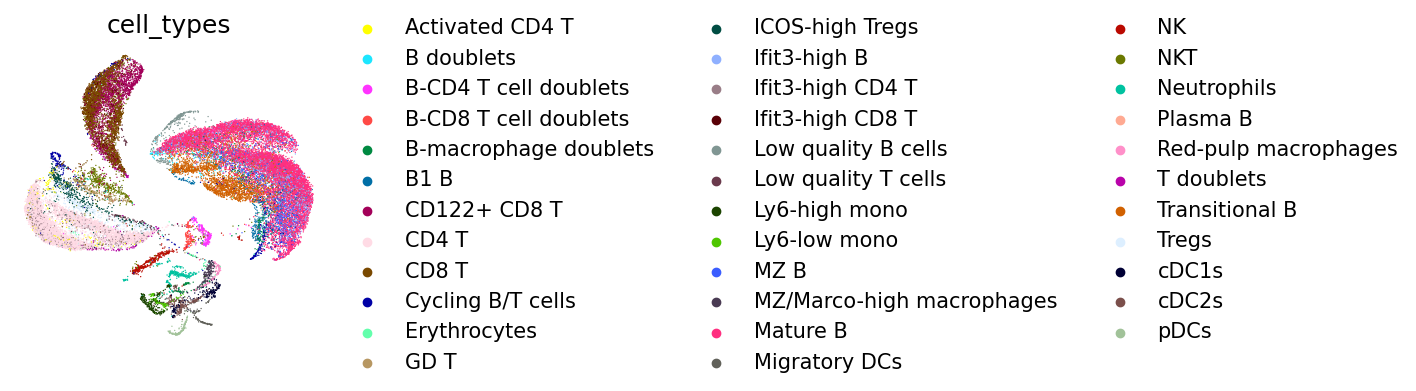

Epoch 1/10 train_loss: 565.07024 val_loss: 136.04790
Epoch 2/10 train_loss: 474.98990 val_loss: 106.48805
Epoch 3/10 train_loss: 347.41854 val_loss: 69.44375
Epoch 4/10 train_loss: 228.15643 val_loss: 44.51844
Epoch 5/10 train_loss: 169.44869 val_loss: 32.30698
Epoch 6/10 train_loss: 140.03126 val_loss: 26.44612
Epoch 7/10 train_loss: 127.14303 val_loss: 24.24563
Epoch 8/10 train_loss: 122.84389 val_loss: 23.62087
Epoch 9/10 train_loss: 121.01828 val_loss: 23.25664
Epoch 10/10 train_loss: 120.58906 val_loss: 23.13755
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


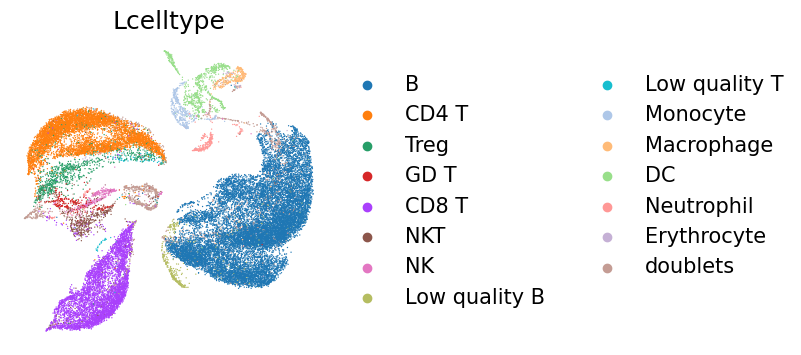

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


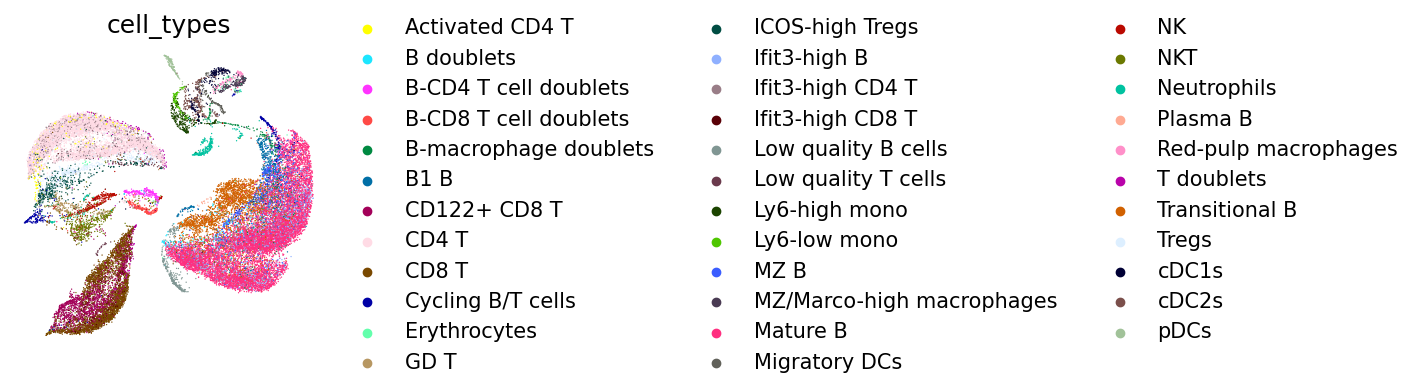

Epoch 1/10 train_loss: 524.82173 val_loss: 124.53943
Epoch 2/10 train_loss: 446.16861 val_loss: 98.31374
Epoch 3/10 train_loss: 324.42834 val_loss: 65.94246
Epoch 4/10 train_loss: 221.51826 val_loss: 42.94795
Epoch 5/10 train_loss: 166.23165 val_loss: 31.17848
Epoch 6/10 train_loss: 136.89892 val_loss: 25.38209
Epoch 7/10 train_loss: 123.58087 val_loss: 23.02445
Epoch 8/10 train_loss: 118.51647 val_loss: 22.34400
Epoch 9/10 train_loss: 117.29835 val_loss: 22.11559
Epoch 10/10 train_loss: 117.18723 val_loss: 21.99084
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


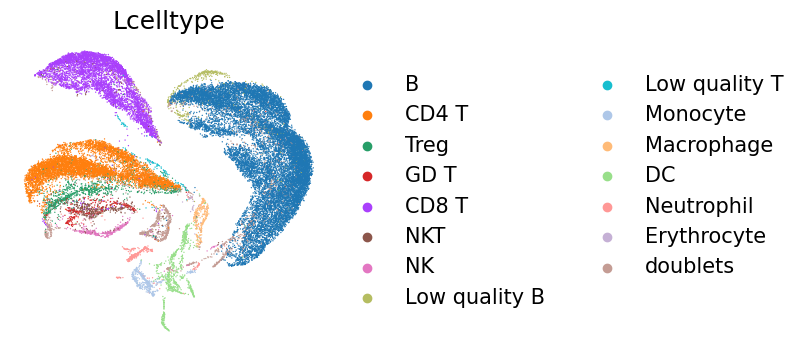

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


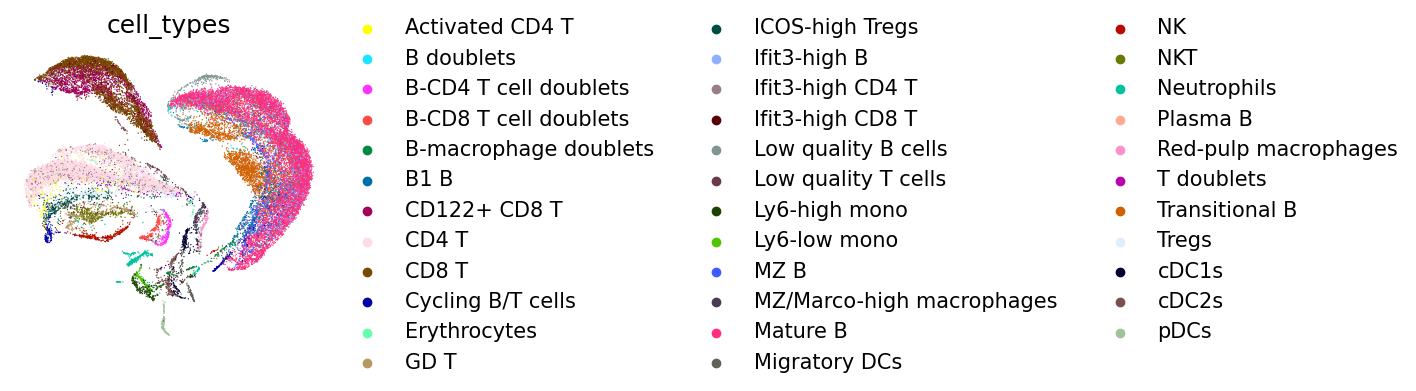

Epoch 1/10 train_loss: 483.10609 val_loss: 111.74806
Epoch 2/10 train_loss: 411.26238 val_loss: 84.88391
Epoch 3/10 train_loss: 280.66052 val_loss: 58.71013
Epoch 4/10 train_loss: 203.48821 val_loss: 38.98949
Epoch 5/10 train_loss: 156.31110 val_loss: 29.14474
Epoch 6/10 train_loss: 132.23421 val_loss: 24.23192
Epoch 7/10 train_loss: 120.21599 val_loss: 22.03436
Epoch 8/10 train_loss: 115.62282 val_loss: 21.30646
Epoch 9/10 train_loss: 114.09538 val_loss: 20.99205
Epoch 10/10 train_loss: 113.34926 val_loss: 20.87076
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


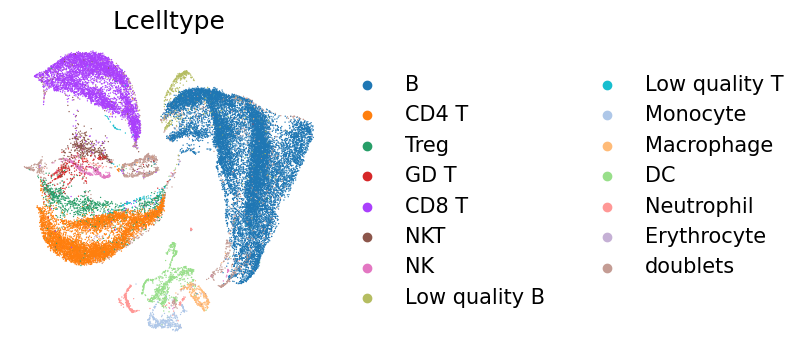

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


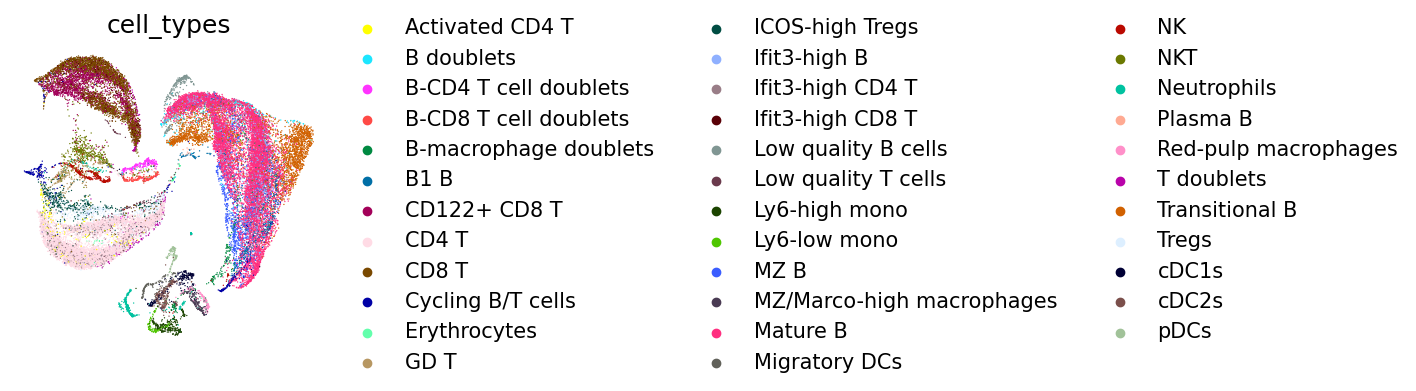

Epoch 1/10 train_loss: 439.46626 val_loss: 95.31122
Epoch 2/10 train_loss: 361.96206 val_loss: 77.04812
Epoch 3/10 train_loss: 260.87346 val_loss: 54.98435
Epoch 4/10 train_loss: 194.35061 val_loss: 37.91551
Epoch 5/10 train_loss: 152.60472 val_loss: 28.27177
Epoch 6/10 train_loss: 128.85903 val_loss: 23.25641
Epoch 7/10 train_loss: 116.87326 val_loss: 20.97000
Epoch 8/10 train_loss: 112.18549 val_loss: 20.07086
Epoch 9/10 train_loss: 110.50175 val_loss: 19.81048
Epoch 10/10 train_loss: 109.55247 val_loss: 19.65060
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


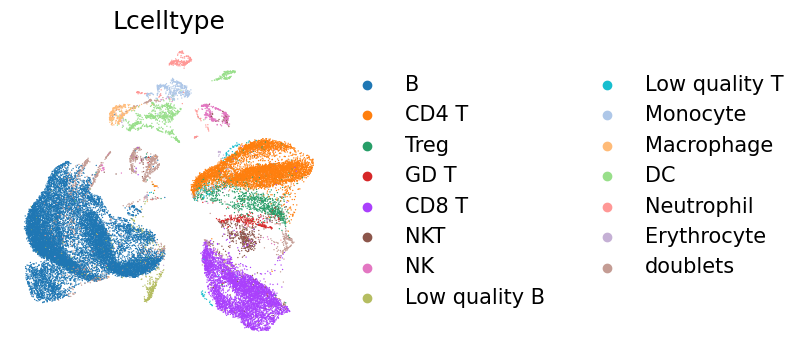

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


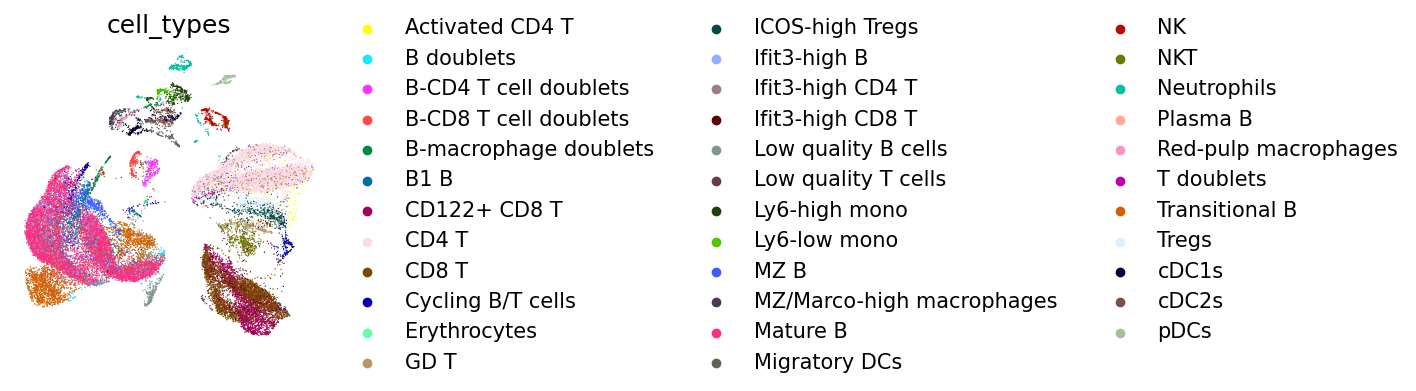

Epoch 1/10 train_loss: 397.37193 val_loss: 84.52298
Epoch 2/10 train_loss: 328.70892 val_loss: 63.77723
Epoch 3/10 train_loss: 225.14421 val_loss: 46.00459
Epoch 4/10 train_loss: 173.62865 val_loss: 32.85688
Epoch 5/10 train_loss: 140.66440 val_loss: 25.44347
Epoch 6/10 train_loss: 122.67202 val_loss: 21.58129
Epoch 7/10 train_loss: 113.04862 val_loss: 19.64983
Epoch 8/10 train_loss: 108.66596 val_loss: 18.92762
Epoch 9/10 train_loss: 107.08348 val_loss: 18.63706
Epoch 10/10 train_loss: 106.40467 val_loss: 18.73285
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


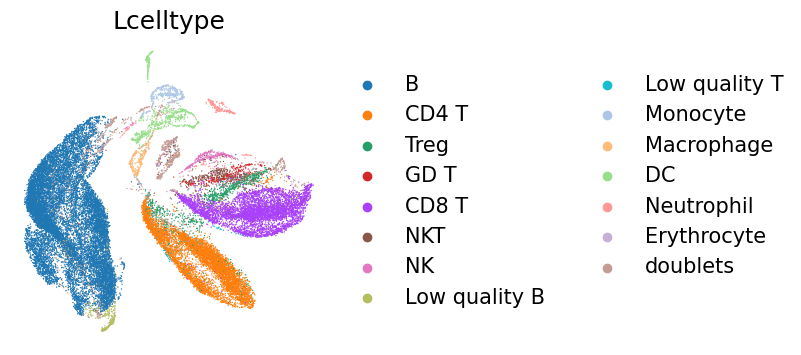

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


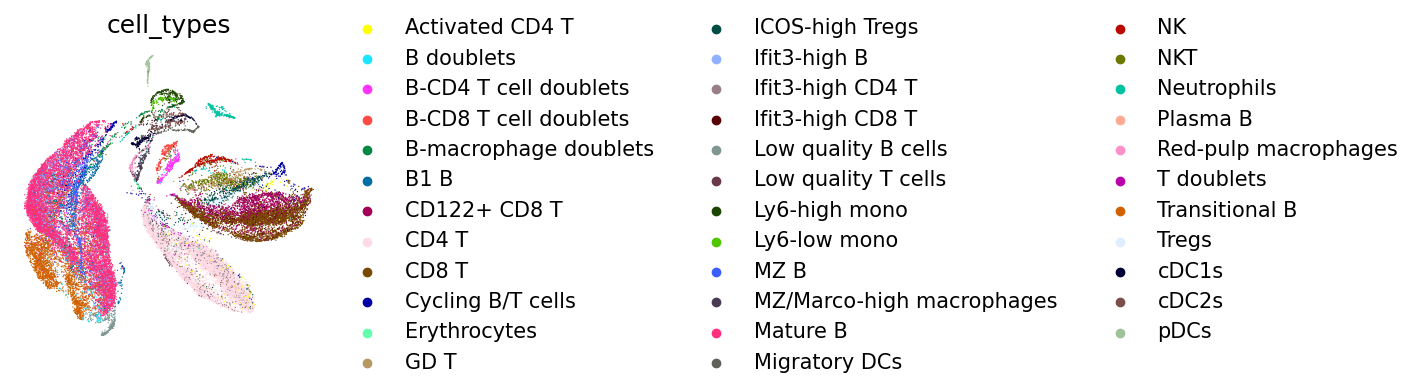

Epoch 1/10 train_loss: 353.84917 val_loss: 70.40592
Epoch 2/10 train_loss: 293.85267 val_loss: 56.87526
Epoch 3/10 train_loss: 219.37124 val_loss: 40.60298
Epoch 4/10 train_loss: 160.01470 val_loss: 29.70921
Epoch 5/10 train_loss: 132.18368 val_loss: 23.41353
Epoch 6/10 train_loss: 117.16054 val_loss: 20.18755
Epoch 7/10 train_loss: 108.98884 val_loss: 18.59299
Epoch 8/10 train_loss: 105.02286 val_loss: 17.65008
Epoch 9/10 train_loss: 103.27656 val_loss: 17.45428
Epoch 10/10 train_loss: 102.71142 val_loss: 17.34672
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


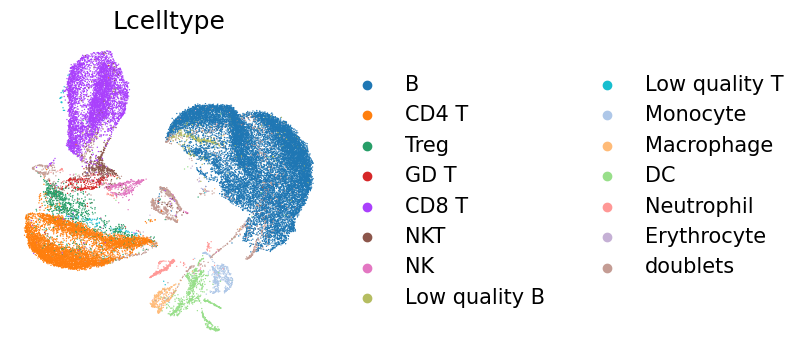

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


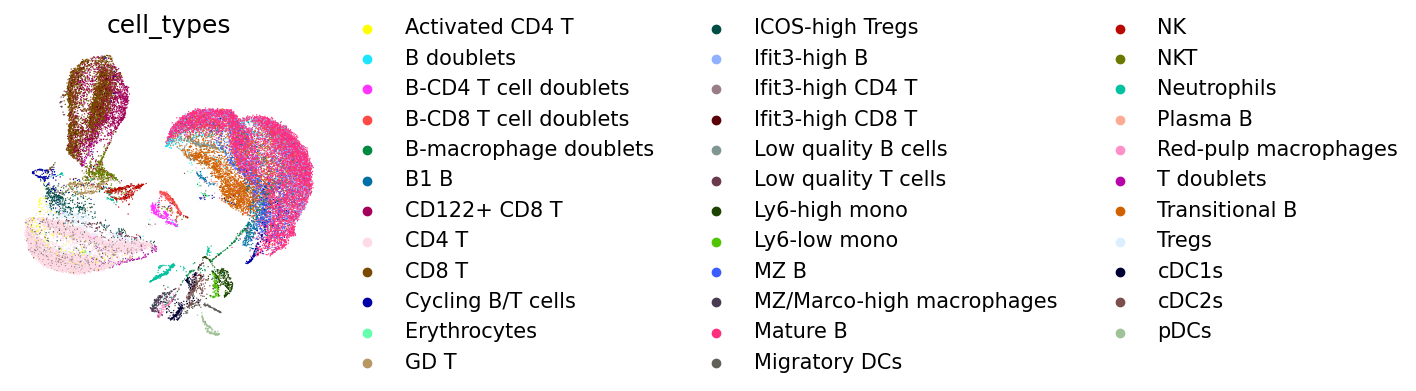

Epoch 1/10 train_loss: 311.53774 val_loss: 56.62014
Epoch 2/10 train_loss: 245.04365 val_loss: 41.72822
Epoch 3/10 train_loss: 169.07990 val_loss: 34.67971
Epoch 4/10 train_loss: 148.02716 val_loss: 28.48421
Epoch 5/10 train_loss: 129.55905 val_loss: 23.05800
Epoch 6/10 train_loss: 115.72050 val_loss: 19.73268
Epoch 7/10 train_loss: 107.33310 val_loss: 17.86930
Epoch 8/10 train_loss: 102.69912 val_loss: 16.87071
Epoch 9/10 train_loss: 100.34148 val_loss: 16.39675
Epoch 10/10 train_loss: 99.22815 val_loss: 16.24630
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


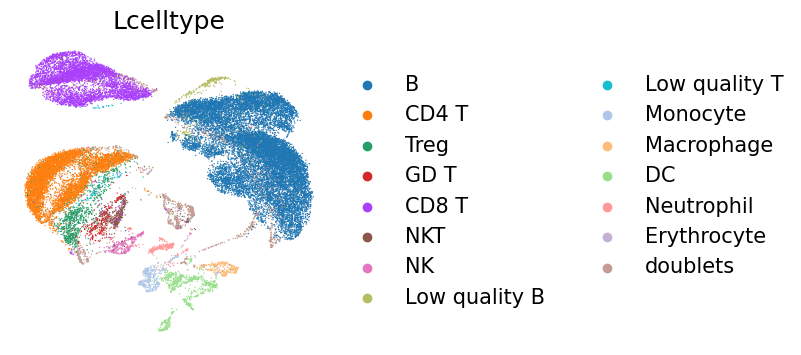

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


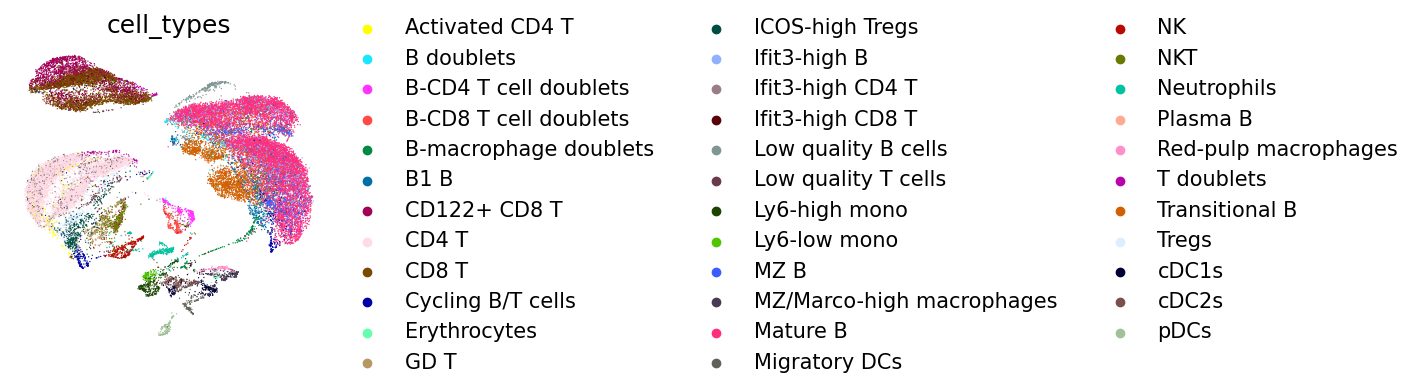

Epoch 1/10 train_loss: 257.95354 val_loss: 38.16468
Epoch 2/10 train_loss: 195.59111 val_loss: 30.28249
Epoch 3/10 train_loss: 138.68092 val_loss: 27.01976
Epoch 4/10 train_loss: 128.40881 val_loss: 23.94631
Epoch 5/10 train_loss: 118.39804 val_loss: 20.55956
Epoch 6/10 train_loss: 108.80292 val_loss: 17.97942
Epoch 7/10 train_loss: 102.44020 val_loss: 16.44254
Epoch 8/10 train_loss: 98.85637 val_loss: 15.69528
Epoch 9/10 train_loss: 96.69308 val_loss: 15.31311
Epoch 10/10 train_loss: 95.79038 val_loss: 15.01615
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


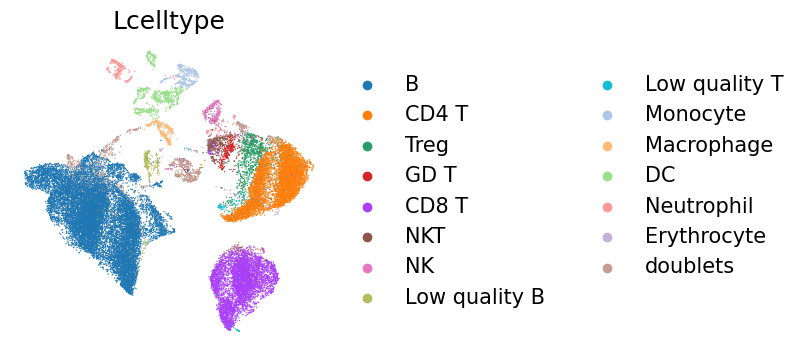

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


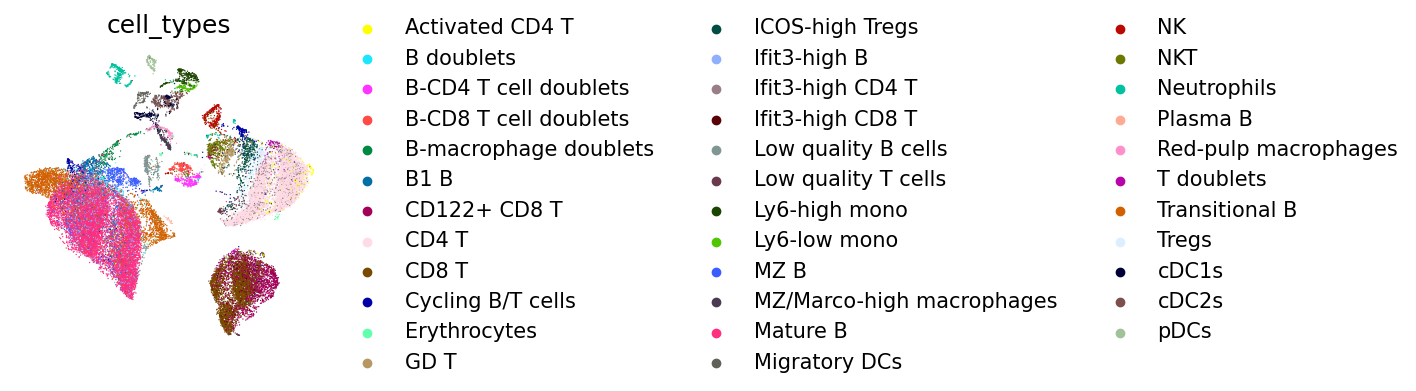

In [24]:
for alpha in range(1, 10, 1):
    trainer = Trainer(
        training_data,
        model_choice=model_choice,
        rna_input_dim=rna_input_dim,
        prot_input_dim=prot_input_dim,
        hidden_dim=hidden_dim,
        embedding_dim=embedding_dim,
        heads=heads,
        num_blocks=num_blocks,
        batch_size=batch_size,
        lr=lr,
        epochs=epochs,
        mask_ratio=mask_ratio,
        permute=permute,
        preserve_rate=preserve_rate,
        num_splits=num_splits,
        device=device,
        alpha=alpha/10,
        beta=beta,
        GAT_encoding=GAT_encoding,
    )

    trainer.train(plot_loss=False)
    mudata.obsm["GCAT_embedding"] = trainer.get_embedding(graph_data)
    sc.pp.neighbors(mudata, use_rep="GCAT_embedding", key_added="GCAT_neighbors")
    sc.tl.umap(mudata, random_state=1, neighbors_key="GCAT_neighbors")
    mu.pl.umap(mudata, color=['Lcelltype'], frameon=False)
    mu.pl.umap(mudata, color=["cell_types"], frameon=False)
    # mu.pl.umap(mudata, color=["batch"], frameon=False)
    plt.show()

16.0


Epoch 1/10 train_loss: 332.69710 val_loss: 82.73072
Epoch 2/10 train_loss: 331.38402 val_loss: 82.40677
Epoch 3/10 train_loss: 329.23447 val_loss: 81.80226
Epoch 4/10 train_loss: 326.26524 val_loss: 81.11926
Epoch 5/10 train_loss: 323.26927 val_loss: 80.70825
Epoch 6/10 train_loss: 320.39227 val_loss: 80.17978
Epoch 7/10 train_loss: 317.90626 val_loss: 79.54385
Epoch 8/10 train_loss: 315.96943 val_loss: 79.34776
Epoch 9/10 train_loss: 313.76766 val_loss: 78.70596
Epoch 10/10 train_loss: 311.44500 val_loss: 78.15489
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


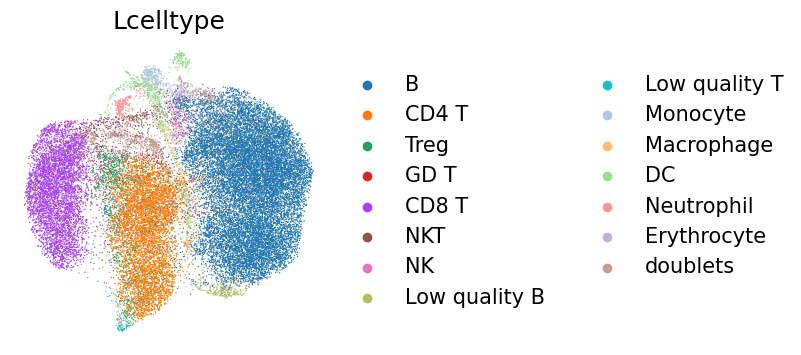

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


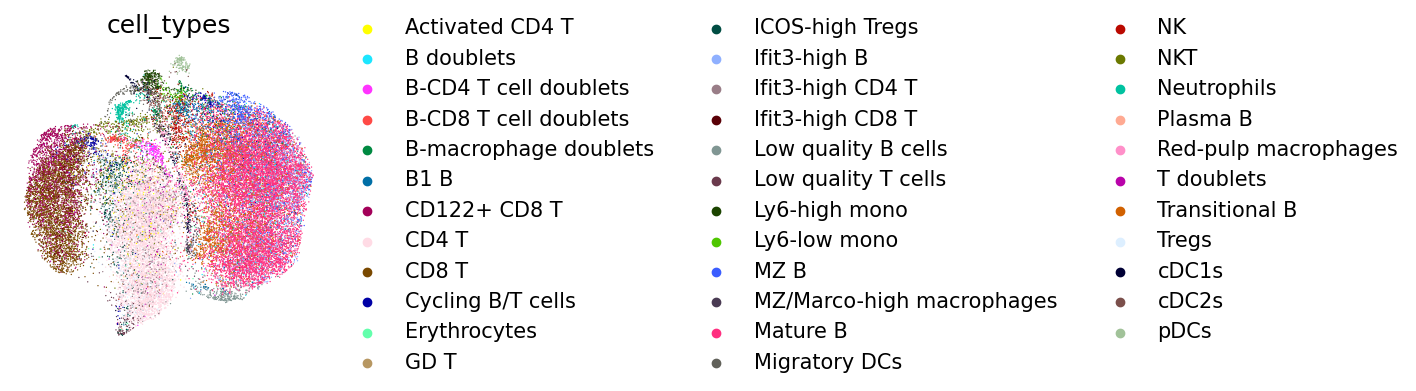

32.0
Epoch 1/10 train_loss: 349.39605 val_loss: 84.34349
Epoch 2/10 train_loss: 346.91657 val_loss: 83.70646
Epoch 3/10 train_loss: 343.89094 val_loss: 82.82115
Epoch 4/10 train_loss: 337.43095 val_loss: 81.40947
Epoch 5/10 train_loss: 330.13177 val_loss: 80.05611
Epoch 6/10 train_loss: 323.02527 val_loss: 78.84539
Epoch 7/10 train_loss: 316.79983 val_loss: 77.61849
Epoch 8/10 train_loss: 311.61207 val_loss: 76.70329
Epoch 9/10 train_loss: 305.48356 val_loss: 75.67231
Epoch 10/10 train_loss: 300.14934 val_loss: 74.59904
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


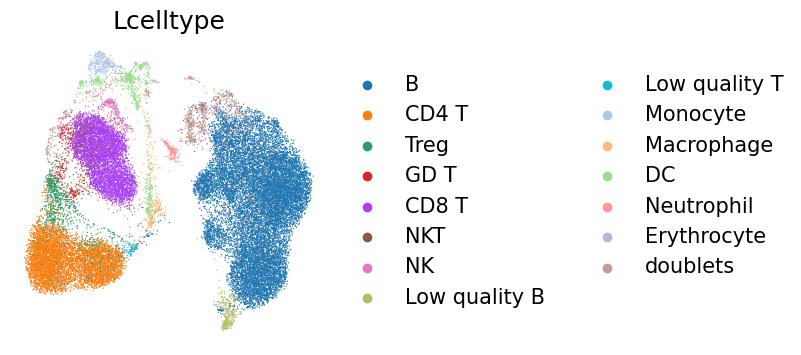

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


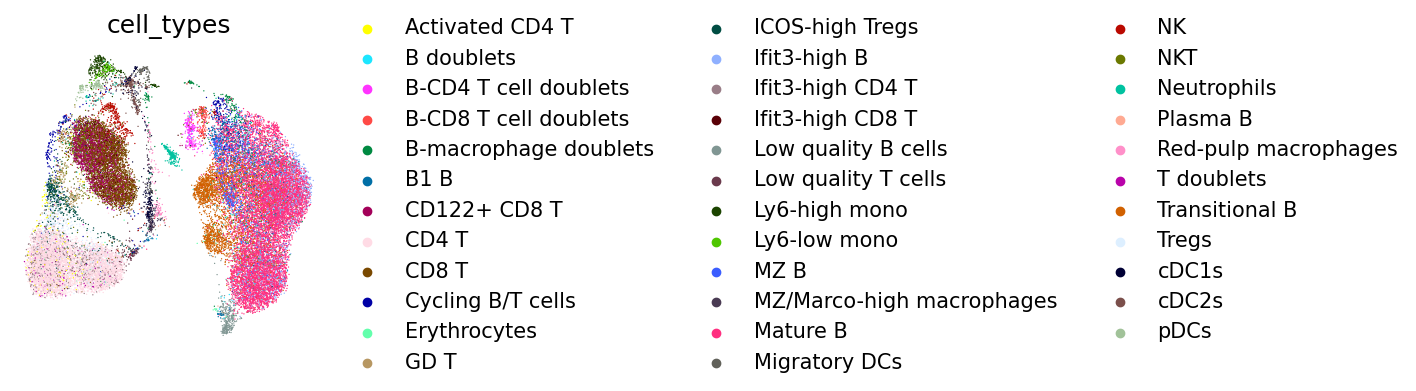

64.0
Epoch 1/10 train_loss: 368.59766 val_loss: 87.04466
Epoch 2/10 train_loss: 364.28488 val_loss: 84.95993
Epoch 3/10 train_loss: 345.54444 val_loss: 79.86878
Epoch 4/10 train_loss: 323.25110 val_loss: 76.70218
Epoch 5/10 train_loss: 308.50534 val_loss: 74.08911
Epoch 6/10 train_loss: 289.89439 val_loss: 70.98610
Epoch 7/10 train_loss: 272.57947 val_loss: 68.06896
Epoch 8/10 train_loss: 260.13169 val_loss: 65.30507
Epoch 9/10 train_loss: 249.33977 val_loss: 62.40701
Epoch 10/10 train_loss: 239.83634 val_loss: 59.59528
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


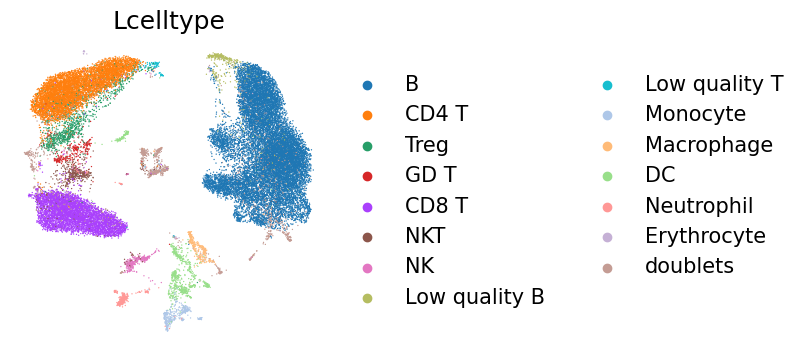

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


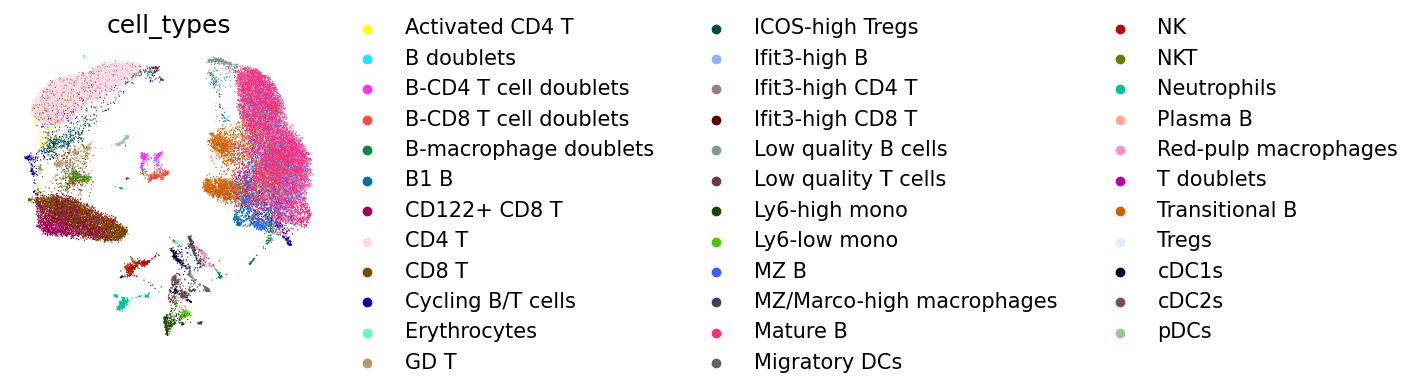

128.0
Epoch 1/10 train_loss: 384.87732 val_loss: 87.57141
Epoch 2/10 train_loss: 366.14106 val_loss: 78.99109
Epoch 3/10 train_loss: 320.19598 val_loss: 71.82840
Epoch 4/10 train_loss: 272.34932 val_loss: 62.91518
Epoch 5/10 train_loss: 235.12343 val_loss: 55.43876
Epoch 6/10 train_loss: 211.44740 val_loss: 47.92792
Epoch 7/10 train_loss: 188.77715 val_loss: 40.88635
Epoch 8/10 train_loss: 168.57593 val_loss: 35.01390
Epoch 9/10 train_loss: 151.86651 val_loss: 30.55486
Epoch 10/10 train_loss: 139.07047 val_loss: 27.03810
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


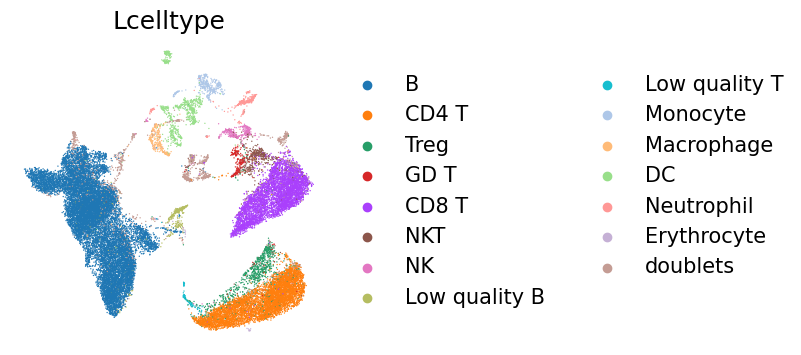

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


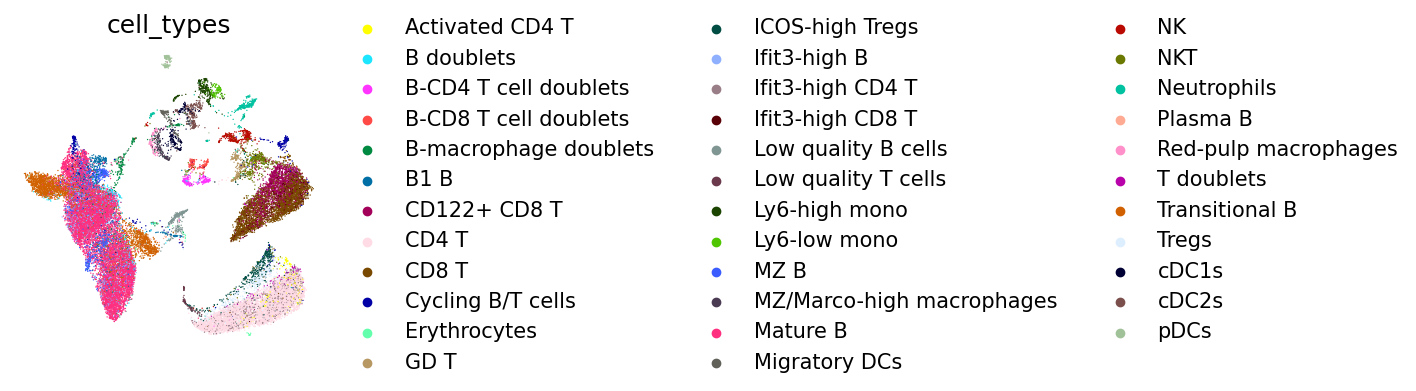

256.0
Epoch 1/10 train_loss: 397.97123 val_loss: 84.96941
Epoch 2/10 train_loss: 343.34509 val_loss: 66.13715
Epoch 3/10 train_loss: 244.75408 val_loss: 46.67125
Epoch 4/10 train_loss: 175.37416 val_loss: 33.48272
Epoch 5/10 train_loss: 142.33336 val_loss: 25.84034
Epoch 6/10 train_loss: 123.10880 val_loss: 21.66203
Epoch 7/10 train_loss: 113.26105 val_loss: 19.75552
Epoch 8/10 train_loss: 108.44967 val_loss: 18.99611
Epoch 9/10 train_loss: 106.95618 val_loss: 18.68970
Epoch 10/10 train_loss: 106.39225 val_loss: 18.48012
Best model saved at split 0


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


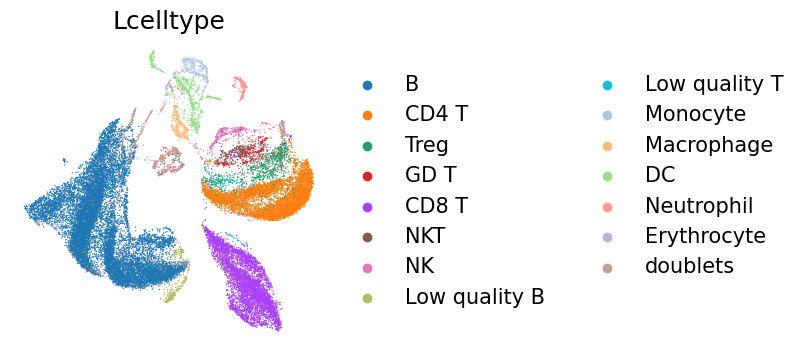

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


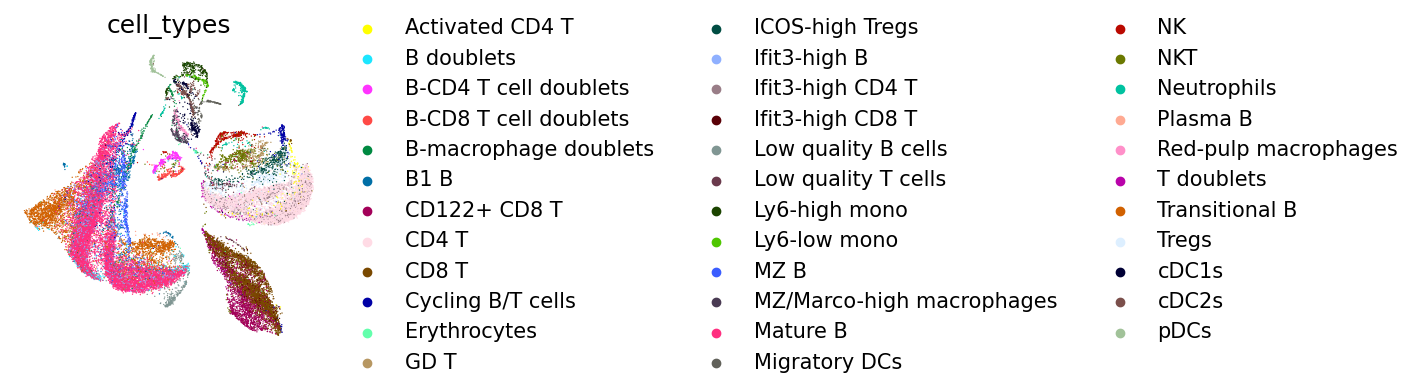

In [26]:
import math

for dim in range(4, 9, 1):
    print(math.pow(2, dim))

    trainer = Trainer(
        training_data,
        model_choice=model_choice,
        rna_input_dim=rna_input_dim,
        prot_input_dim=prot_input_dim,
        hidden_dim=int(math.pow(2, dim)),
        embedding_dim=int(math.pow(2, dim)),
        heads=heads,
        num_blocks=num_blocks,
        batch_size=batch_size,
        lr=lr,
        epochs=epochs,
        mask_ratio=mask_ratio,
        permute=permute,
        preserve_rate=preserve_rate,
        num_splits=num_splits,
        device=device,
        alpha=0.6,
        beta=beta,
        GAT_encoding=GAT_encoding,
    )

    trainer.train(plot_loss=False)
    mudata.obsm["GCAT_embedding"] = trainer.get_embedding(graph_data)
    sc.pp.neighbors(mudata, use_rep="GCAT_embedding", key_added="GCAT_neighbors")
    sc.tl.umap(mudata, random_state=1, neighbors_key="GCAT_neighbors")
    mu.pl.umap(mudata, color=['Lcelltype'], frameon=False)
    mu.pl.umap(mudata, color=["cell_types"], frameon=False)
    # mu.pl.umap(mudata, color=["batch"], frameon=False)
    plt.show()

In [16]:
mudata.obsm["GCAT_umap"] = mudata.obsm["X_umap"]
mudata.obs['cell_types'] = mudata['rna'].obs["cell_types"]

In [17]:
sc.tl.leiden(mudata, resolution=0.5, key_added="GCAT_leiden", 
            random_state=1, neighbors_key='GCAT_neighbors',)

In [17]:
reassign_cluster_names = {
    "Neutrophils": "Neutrophils",
    "Plasma B": "Plasma B",
    "Red-pulp macrophages": "Macrophage",
    "T doublets": "doublets",
    "Transitional B": "Transitional B",
    "Tregs": "Treg",
    "cDC1s": "DC",
    "cDC2s": "DC",
    "pDCs": "DC",
    "B doublets": "doublets",
    "B-CD4 T cell doublets": "doublets",
    "B-CD8 T cell doublets": "doublets",
    "B-macrophage doublets": "doublets",
    "B1 B": "B1 B",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Cycling B/T cells": "Cycling B/T cells",
    "Erythrocytes": "Erythrocyte",
    "GD T": "GD T",
    "ICOS-high Tregs": "Treg",
    "Activated CD4 T": "CD4 T",
    "Ifit3-high B": "Ifit3-high B",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Low quality B cells": "Low quality B",
    "Low quality T cells": "Low quality T",
    "Ly6-high mono": "Monocyte",
    "Ly6-low mono": "Monocyte",
    "MZ B": "MZ B",
    "MZ/Marco-high macrophages": "Macrophage",
    "Mature B": "Mature B",
    "Migratory DCs": "DC",
    "NK": "NK",
    "NKT": "NKT",
}
mudata['rna'].obs['Lcelltype'] = mudata['rna'].obs['cell_types'].map(reassign_cluster_names).astype('category')

In [18]:
reassign_cluster_names = {
    "Neutrophils": "Neutrophil",
    "Plasma B": "B",
    "Red-pulp macrophages": "Macrophage",
    "T doublets": "doublets",
    "Transitional B": "B",
    "Tregs": "Treg",
    "cDC1s": "DC",
    "cDC2s": "DC",
    "pDCs": "DC",
    "B doublets": "doublets",
    "B-CD4 T cell doublets": "doublets",
    "B-CD8 T cell doublets": "doublets",
    "B-macrophage doublets": "doublets",
    "B1 B": "B",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Cycling B/T cells": "doublets",
    "Erythrocytes": "Erythrocyte",
    "GD T": "GD T",
    "ICOS-high Tregs": "Treg",
    "Activated CD4 T": "CD4 T",
    "Ifit3-high B": "B",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Low quality B cells": "Low quality B",
    "Low quality T cells": "Low quality T",
    "Ly6-high mono": "Monocyte",
    "Ly6-low mono": "Monocyte",
    "MZ B": "B",
    "MZ/Marco-high macrophages": "Macrophage",
    "Mature B": "B",
    "Migratory DCs": "DC",
    "NK": "NK",
    "NKT": "NKT",
}
mudata['rna'].obs['Lcelltype'] = mudata['rna'].obs['cell_types'].map(reassign_cluster_names).astype('category')

In [19]:
mudata.obs['Lcelltype'] = mudata['rna'].obs['Lcelltype']

In [20]:
mudata.obs['Lcelltype'] = mudata.obs['Lcelltype'].cat.reorder_categories(['B', 'CD4 T','Treg','GD T', 'CD8 T','NKT','NK', 
                                                                         'Low quality B','Low quality T',
                                                                         'Monocyte','Macrophage','DC','Neutrophil', 
                                                                         'Erythrocyte','doublets'])

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


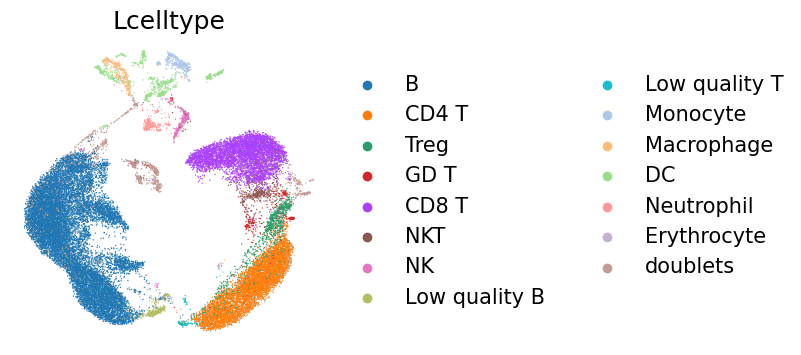

In [21]:
mu.pl.umap(mudata, color=['Lcelltype'], frameon=False)

In [22]:
mudata

MuData object with n_obs × n_vars = 32648 × 13663
  obs:	'batch', 'cell_types', 'GCAT_leiden', 'Lcelltype'
  uns:	'GCAT_neighbors', 'umap', 'leiden', 'Lcelltype_colors'
  obsm:	'GCAT_embedding', 'X_umap', 'GCAT_umap'
  obsp:	'GCAT_neighbors_distances', 'GCAT_neighbors_connectivities'
  2 modalities
    rna:	32648 x 13553
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Lcelltype'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    prot:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'

## With whole transcriptomics

In [3]:
mdata = mu.read_h5mu(f"{save_path}scCITE_combine.h5mu")
mdata

MuData object with n_obs × n_vars = 32648 × 13760
  2 modalities
    rna:	32648 x 13553
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 207
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'
      layers:	'counts'

In [4]:
mdata.update()

In [5]:
gene_dict = {
    "Atn1-1": "Atn1",
    "Dancr-1": "Dancr",
    "Gbp6-1": "Gbp6",
    "Hist2h2bb-1": "Hist2h2bb",
    "Itgam-1": "Itgam",
    "Pcdhga8-1": "Pcdhga8",
    "Smim20-1": "Smim20",
    "U2af1l4-1": "U2af1l4",
}

In [6]:
# replace var_names using gene_dict
for k, v in gene_dict.items():
    mdata.mod['rna'].var_names = mdata.mod['rna'].var_names.str.replace(k, v)

In [7]:
# find the repeated gene names and only keep the first one
gene_names = mdata.mod['rna'].var_names
gene_names = pd.Series(gene_names)
# gene_names[gene_names.duplicated(keep=False)]
gene_names = gene_names[~gene_names.duplicated(keep='first')]
gene_names

0                Mrpl15
1                Lypla1
2                 Tcea1
3               Atp6v1h
4                Rb1cc1
              ...      
13548        AC125149.3
13549        AC168977.1
13550              PISD
13551             DHRSX
13552    CAAA01147332.1
Name: index, Length: 13548, dtype: object

In [8]:
mdata.mod["rna"] = mdata.mod['rna'][:, gene_names.index]
mdata

MuData object with n_obs × n_vars = 32648 × 13760
  2 modalities
    rna:	32648 x 13548
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 207
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'
      layers:	'counts'

In [11]:
gtf_path = "/DATA/User/wuxinchao/st_cite_data/ref/Mus_musculus.GRCm38.84.gtf"
geneVocab = GeneVocab(mdata.mod['rna'])
geneVocab.sort_by_genomic_position(gtf_path)
sc_rna_data = geneVocab.align_features(mdata.mod['rna'])
sc_prot_data = mdata.mod['protein'][mdata.mod['rna'].obs_names]
sc_rna_data.obsp = mdata.mod['rna'].obsp
# sc_prot_data.var_names = sc_prot_data.var_names.str.split("_").str[-2]

In [12]:
model_choice = "Graph Cross Attention"

rna_input_dim = sc_rna_data.X.shape[1]
prot_input_dim = sc_prot_data.X.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

scData = SinglecellData(mdata, geneVocab)

num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData.data)

In [13]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=20,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/20 train_loss: 146.27597 val_loss: 24.06301
Epoch 2/20 train_loss: 53.28050 val_loss: 12.31422
Epoch 3/20 train_loss: 31.94877 val_loss: 9.76670
Epoch 4/20 train_loss: 28.22417 val_loss: 9.54354
Epoch 5/20 train_loss: 27.86188 val_loss: 9.51136
Epoch 6/20 train_loss: 27.74926 val_loss: 9.46362
Epoch 7/20 train_loss: 27.54523 val_loss: 9.35885
Epoch 8/20 train_loss: 27.19448 val_loss: 9.23387
Epoch 9/20 train_loss: 26.56117 val_loss: 8.97669
Epoch 10/20 train_loss: 25.77815 val_loss: 8.75822
Epoch 11/20 train_loss: 25.16904 val_loss: 8.57291
Epoch 12/20 train_loss: 24.70059 val_loss: 8.45274
Epoch 13/20 train_loss: 24.32517 val_loss: 8.37154
Epoch 14/20 train_loss: 24.11567 val_loss: 8.31517
Epoch 15/20 train_loss: 23.90126 val_loss: 8.26958
Epoch 16/20 train_loss: 23.76920 val_loss: 8.21635
Epoch 17/20 train_loss: 23.62305 val_loss: 8.15923
Epoch 18/20 train_loss: 23.50937 val_loss: 8.13411
Epoch 19/20 train_loss: 23.42136 val_loss: 8.11693
Epoch 20/20 train_loss: 23.29162 val_

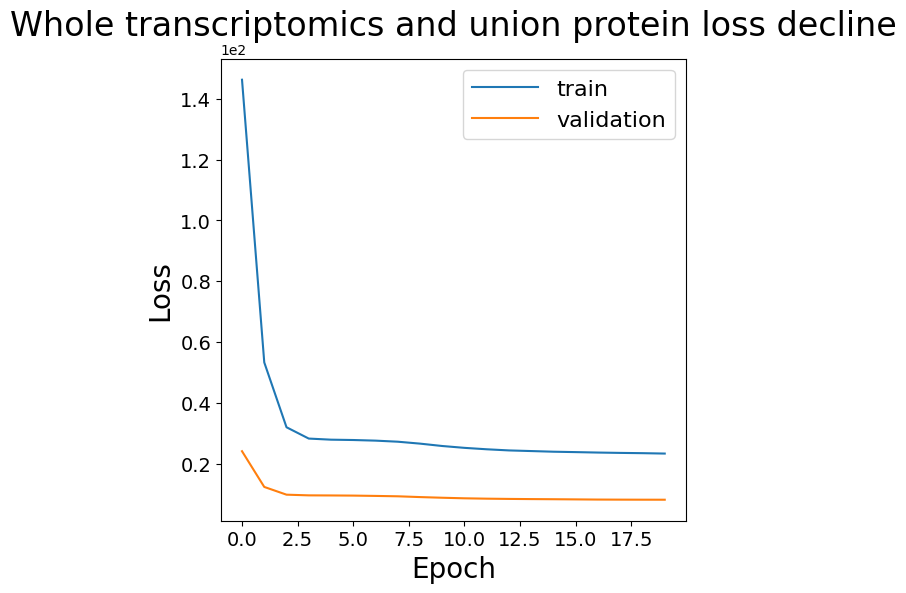

In [14]:
# plot the training and validation loss
plt.figure(figsize=(6,6))
plt.plot(train_losses[0], label="train")
plt.plot(val_losses[0], label="validation")
plt.title("Whole transcriptomics and union protein loss decline", fontsize=24)
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 16, 'weight': 'normal'}, handlelength=3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("scCITE_whole_trans_training_union_loss.png")

In [15]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/scCITE_seq_whole_union.pt")

In [16]:
model = trainer.best_model

In [17]:
adj_mtx = rna_adata_pool_subset.obsp['connectivities'].toarray()
edge_index = adj_mtx.nonzero()
edge_index = np.array(edge_index)
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous().to(device)
concat_data = np.concatenate((sc_rna_data.X, sc_prot_data.X), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

NameError: name 'rna_adata_pool_subset' is not defined

In [ ]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [122]:
from scipy.sparse import csr_matrix, save_npz

rna_recon = csr_matrix(rna_recon)
prot_recon = csr_matrix(prot_recon)
save_npz("../data/GraphCrossRNArecon_combined_whole_trans_intersect_SLN_scCITE.npz", rna_recon)
save_npz("../data/GraphCrossPorteinrecon_combined_whole_trans_intersect_SLN_scCITE.npz", prot_recon)
# np.save("../data/GraphCrossRNArecon_combined_intersect_SLN_scCITE.npy", rna_recon)
# np.save("../data/GraphCrossPorteinrecon_combined_intersect_SLN_scCITE.npy", prot_recon)

In [ ]:
np.save("../data/GraphCrossEmbedding_combined_whole_trans_union_SLN_scCITE.npy", embedding)

In [125]:
mdata

MuData object with n_obs × n_vars = 32648 × 13658
  2 modalities
    rna:	32648 x 13548
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'

# spatial

## spCITE spleen mouse

In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import scvi

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
mdata = mu.read_h5mu("/home/wuxinchao/data/st_cite_data/spatial_cite_data/mouse_spleen_spCITE.h5mu")

In [3]:
rna_adata = mdata.mod['rna']
prot_adata = mdata.mod["prot"]

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


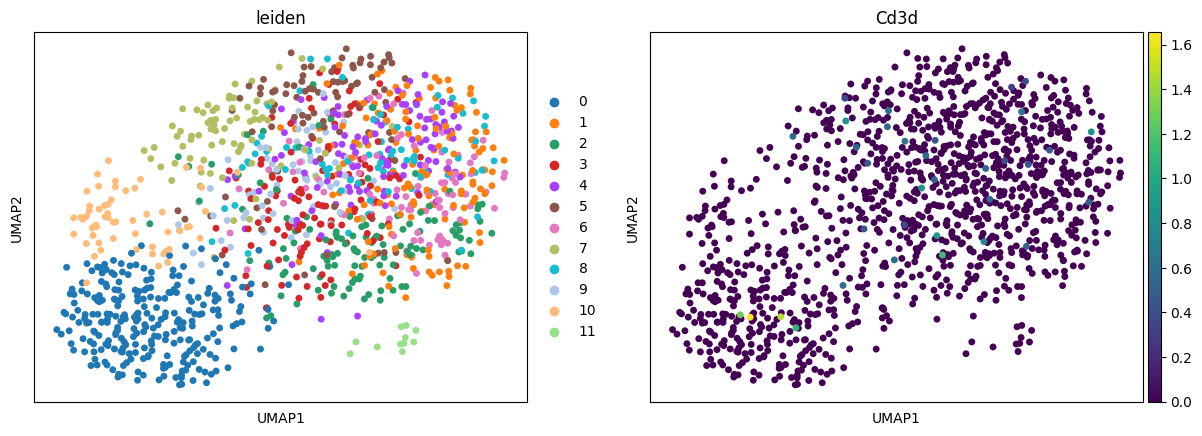

In [149]:
rna_adata.layers["counts"] = rna_adata.X.copy()
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
rna_adata.obs_names_make_unique()

sc.pp.highly_variable_genes(
    rna_adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    # batch_key="batch",
    layer="counts",
)
rna_adata.raw = rna_adata
sc.pp.scale(rna_adata, max_value=10)
sc.tl.pca(rna_adata, svd_solver='arpack')
sc.pp.neighbors(rna_adata, n_neighbors=10, n_pcs=50)

sc.tl.leiden(rna_adata, resolution=1)
sc.tl.umap(rna_adata, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna_adata, color=['leiden','Cd3d'])

In [147]:
# int(rna_adata.obs["x"]), int(rna_adata.obs["y"])
rna_adata.obs["x"] = rna_adata.obs["x"].astype(float)
rna_adata.obs["y"] = rna_adata.obs["y"].astype(float)
rna_adata.obsm["spatial"] = rna_adata.obs[["x", "y"]].values

In [154]:
prot_adata.obs[["x", "y"]] = rna_adata.obs[["x", "y"]]

In [155]:
prot_adata.obs["x"] = prot_adata.obs["x"].astype(float)
prot_adata.obs["y"] = prot_adata.obs["y"].astype(float)
prot_adata.obsm["spatial"] = prot_adata.obs[["x", "y"]].values

In [283]:
mdata.write("/home/wuxinchao/data/st_cite_data/spatial_cite_data/mouse_spleen_spCITE.h5mu")

In [7]:
highly_variable = pd.read_csv(f"{save_path}/scCITE_hvg.csv")

In [8]:
# rna_adata[:,highly_variable.iloc[:,0]]
rna_adata_hvg_transfer = rna_adata[:, rna_adata.var_names.isin(highly_variable.iloc[:,0].to_list())]
rna_adata_hvg_transfer

View of AnnData object with n_obs × n_vars = 1222 × 3210
    obs: 'n_genes', 'x', 'y', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_proximity'

In [9]:
# new_exp = np.zeros_like((rna_adata_hvg_transfer.shape[0], len(highly_variable)-1))
highly_variable.index = highly_variable.iloc[:,0]
highly_variable = highly_variable.T
highly_variable = highly_variable.drop('0')

In [10]:
for i, gene_name in enumerate(rna_adata_hvg_transfer.var_names):
    highly_variable[gene_name] = rna_adata_hvg_transfer.X[:,i]
# highly_variable["Akap12"] = rna_adata_hvg_transfer.X[:,2]

In [11]:
highly_variable = highly_variable.fillna(0)

In [12]:
prot_adata.layers["counts"] = prot_adata.X.copy()

In [13]:
prot_adata.X = prot_adata.layers["counts"].copy()
sc.pp.normalize_total(prot_adata, target_sum=1e4)
sc.pp.log1p(prot_adata)

In [14]:
# ''.join(filter(str.isalnum, prot_adata.var_names[prot_adata.var_names.str.contains("CD")].to_list()[0].lower()))
list1 = [i[:-1] for i in protein_adata_intersect.var_names.str.replace("ADT_", "").str.split("_")]
list2 = prot_adata.var_names.to_list()
result = {}
for i, protein1 in enumerate(list1):
    for j, protein2 in enumerate(list2):
        # print(protein1), print(protein2)
        if ''.join(filter(str.isalnum, protein1[0].lower())) in ''.join(filter(str.isalnum, protein2.lower())):
            # result[protein1[0]] = f"index of list 1: {i} (name in list 1: {protein1}), index of list 2: {j} (name in list 2: {protein2})"
            result[protein1[0]] = [i, j]
            break

In [16]:
new_prot_exp = pd.DataFrame(columns = protein_adata_intersect.var_names)
for protein in result:
    new_prot_exp[new_prot_exp.columns[result[protein][0]]] = prot_adata.X[:, result[protein][1]]
new_prot_exp = new_prot_exp.fillna(0)

In [264]:
import numpy as np

# Function to calculate Euclidean distance between two spots
def euclidean_distance(s_i, s_j):
    return np.sqrt((s_i[0] - s_j[0])**2 + (s_i[1] - s_j[1])**2)

# Function to calculate the weight based on the exponential decay function
def exponential_decay(d, alpha):
    return np.exp(-alpha * d)

# Function to build the weighted adjacency matrix
def build_adjacency_matrix(spots, alpha):
    n = len(spots)  # Number of spots
    W = np.zeros((n, n))  # Initialize the adjacency matrix
    
    # Iterate through each pair of spots to fill the adjacency matrix
    for i in range(n):
        for j in range(n):
            if i != j:  # No self-connections
                d = euclidean_distance(spots[i], spots[j])
                W[i, j] = exponential_decay(d, alpha)
    
    return W

In [274]:
rna_adata.obsp["spatial_proximity"] = build_adjacency_matrix(prot_adata.obsm["spatial"], 0.5)

In [17]:
highly_variable.shape, new_prot_exp.shape

((1222, 4000), (1222, 110))

In [18]:
rna_input = highly_variable.values[:, :-1]
prot_input = new_prot_exp.values

In [52]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_input.shape[1]
prot_input_dim = prot_input.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = rna_adata.obsp['spatial_proximity']
edge_index = adj_mtx.nonzero()
edge_index = np.array(edge_index)
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous().to(device)
concat_data = np.concatenate((rna_input, prot_input), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 1
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [73]:
scData

Data(x=[1222, 4109], edge_index=[2, 1492062], train_mask=[1222], val_mask=[1222], test_mask=[1222])

In [20]:
# loading the pre-trained model
from model import GraphCrossAttn

model = GraphCrossAttn(
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
).to(device)

# load the pre-trained model
# model.load_state_dict(torch.load("../save_model/scCITE_intersect_hvg.pt")["model"])

<All keys matched successfully>

In [53]:
training_data

Data(x=[1222, 4109], edge_index=[2, 1492062], train_mask=[1222], val_mask=[1222], test_mask=[1222])

In [60]:
import importlib
import sys

importlib.reload(sys.modules['train'])

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [63]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.75,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses = trainer.fine_tune(model=model, epochs=10, 
                    model_name="scCITE_intersect_hvg.pt", save_name="sc_spCITE_spleen_mouse_transfer.pt")

Epoch 1/10, Loss: 3.179643233617147
Epoch 2/10, Loss: 2.289055426915487
Epoch 3/10, Loss: 1.7865444421768188
Epoch 4/10, Loss: 1.7076302766799927
Epoch 5/10, Loss: 1.694178581237793
Epoch 6/10, Loss: 1.6648138761520386
Epoch 7/10, Loss: 1.6124885082244873
Epoch 8/10, Loss: 1.5646273692448933
Epoch 9/10, Loss: 1.5310066143671672
Epoch 10/10, Loss: 1.5077422857284546


In [64]:
model.load_state_dict(torch.load("../save_model/best_sc_spCITE_spleen_mouse_transfer.pt")["model"])

<All keys matched successfully>

In [65]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [97]:
# df.DataFrame(mdata.mod['rna'].var[mdata.mod['rna'].var["highly_variable"]].index).to_csv("../data/scCITE_combined_hvg_list.csv")

In [67]:
np.save("../data/GraphCrossRNArecon_intersect_hvg_mouse_spleen_spCITE.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_intersect_hvg_mouse_spleen_spCITE.npy", prot_recon)

In [68]:
np.save("../data/GraphCrossEmbedding_intersect_hvg_mouse_spleen_sp.npy", embedding)

### sp integrate

In [75]:
rna_adata, prot_adata

(AnnData object with n_obs × n_vars = 1222 × 16033
     obs: 'n_genes', 'x', 'y', 'leiden'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'connectivities', 'distances', 'spatial_proximity',
 AnnData object with n_obs × n_vars = 1222 × 193
     obs: 'n_genes', 'x', 'y'
     var: 'n_cells'
     uns: 'log1p'
     obsm: 'spatial'
     layers: 'counts')

In [77]:
rna_adata_subset = rna_adata[:,rna_adata.var['highly_variable']]
rna_adata_subset

View of AnnData object with n_obs × n_vars = 1222 × 4000
    obs: 'n_genes', 'x', 'y', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_proximity'

In [78]:
rna_input = rna_adata_subset.X
prot_input = prot_adata.X

In [81]:
import torch

def build_adjacency_matrix_torch(spots, alpha, T=0.005, device='cuda'):
    spots = torch.tensor(spots, dtype=torch.float32, device=device)
    # Calculate the pairwise Euclidean distances using broadcasting
    diff = spots[:, None, :] - spots[None, :, :]
    distances = torch.sqrt(torch.sum(diff**2, dim=-1))
    
    # Apply the exponential decay function to the distances
    W = torch.exp(-alpha * distances)
    W.masked_fill_(W<T, 0)
    
    # Zero out the diagonal (no self-connections)
    W.fill_diagonal_(0)
    
    return W

In [85]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_input.shape[1]
prot_input_dim = prot_input.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = build_adjacency_matrix_torch(rna_adata_subset.obsm["spatial"], alpha=0.5)
edge_index = adj_mtx.nonzero().T.contiguous().to(device)
concat_data = np.concatenate((rna_input, prot_input), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [88]:
import importlib
import sys

importlib.reload(sys.modules["train"])

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [89]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()
# 32s

Epoch 1/20 train_loss: 22.51069 val_loss: 7.36853
Epoch 2/20 train_loss: 21.97413 val_loss: 7.06932
Epoch 3/20 train_loss: 21.05295 val_loss: 6.61205
Epoch 4/20 train_loss: 19.60207 val_loss: 5.93934
Epoch 5/20 train_loss: 17.62378 val_loss: 5.24630
Epoch 6/20 train_loss: 15.58553 val_loss: 4.71480
Epoch 7/20 train_loss: 13.69946 val_loss: 4.11663
Epoch 8/20 train_loss: 11.90050 val_loss: 3.55900
Epoch 9/20 train_loss: 10.36113 val_loss: 3.14705
Epoch 10/20 train_loss: 9.05988 val_loss: 2.82881
Epoch 11/20 train_loss: 8.09120 val_loss: 2.57403
Epoch 12/20 train_loss: 7.42407 val_loss: 2.38125
Epoch 13/20 train_loss: 6.94001 val_loss: 2.25360
Epoch 14/20 train_loss: 6.57417 val_loss: 2.17295
Epoch 15/20 train_loss: 6.32847 val_loss: 2.10913
Epoch 16/20 train_loss: 6.17013 val_loss: 2.08335
Epoch 17/20 train_loss: 6.06612 val_loss: 2.05556
Epoch 18/20 train_loss: 6.00650 val_loss: 2.03090
Epoch 19/20 train_loss: 5.93739 val_loss: 2.01970
Epoch 20/20 train_loss: 5.87652 val_loss: 2.01176


In [90]:
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/spCITE_seq_integrate.pt")

In [92]:
# model.load_state_dict(torch.load("../save_model/spCITE_seq_integrate.pt")["model"])
model = trainer.best_model

In [93]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [94]:
np.save("../data/GraphCrossRNArecon_human_thymus_spCITE_hvg.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_human_thymus_spCITE_hvg.npy", prot_recon)
np.save("../data/GraphCrossEmbedding_human_thymus_spCITE_hvg.npy", embedding)

In [96]:
%whos

Variable                       Type               Data/Info
-----------------------------------------------------------
Data                           type               <class 'torch_geometric.data.data.Data'>
GeneVocab                      type               <class 'dataset.GeneVocab'>
GraphCrossAttn                 type               <class 'model.GraphCrossAttn'>
RandomNodeSplit                ABCMeta            <class 'torch_geometric.t<...>e_split.RandomNodeSplit'>
SinglecellData                 type               <class 'dataset.SinglecellData'>
Trainer                        type               <class 'train.Trainer'>
ad                             module             <module 'anndata' from '/<...>ges/anndata/__init__.py'>
adj_mtx                        Tensor             tensor([[0.0000, 0.0000, <...>\n       device='cuda:0')
alpha                          float              0.4
batch_size                     int                256
beta                           float           